This notebook pulls the data from the Features.parquet file and is used to validate that we preseve the data accross saves to parquet format. Data should compare with the develop_simple_features.ipynb

In [1]:
# save the variance explained to a pickle file
import joblib
import warnings
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from PIL import Image

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import PCA

# apply TSNE to the Hue, Value, and LBP features
from sklearn.manifold import TSNE

from feature_utils import normalize_histogram

warnings.filterwarnings("ignore")

  Using cached tbb-2021.11.0-py3-none-win_amd64.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/132.6 kB ? eta -:--:--
   --------- ----------------------------- 30.7/132.6 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 132.6/132.6 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ------- -------------------------------- 0.4/2.0 MB 8.1 MB/s eta 0:00:01
   -------------- ------------------------- 0.8/2.0 MB 8.0 MB/s eta 0:00:01
   ------------------------ --------------- 1.2/2.0 MB 8.7 MB/s eta 0:00:01
   ------------------------------------ --- 1.9/2.0 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------  2.0/2.0 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 8.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.3 MB ? eta -:--:--
    --------------------------------------- 0.8/57.3 MB 16.3 MB/s eta 0:00:04
   - ---------------------

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [17]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path("data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)
dft = dft.join(dfm, on="ClassId")
samples_per_class = 200
random_seed = 42
pl.set_random_seed(random_seed)
dft = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, shuffle=False)
        for x in dft.partition_by("ClassId")
    ]
)
# del dfm

In [18]:
dft.head(1)

id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,20,64,64,[binary data],4096,[binary data],"[305, 67, … 89]","[15, 0, … 0]","[0, 0, … 0]",[binary data],"[206, 143, … 0]","[0.233832, 0.040925, … 0.035414]",[binary data],"[0.276675, 0.25271, … 0.150875]","[0.0, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""C:\Users\teddy…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096


In [19]:
dft.shape

# get the list of columns from the dataframe
columns = dft.columns
columns

['id',
 'ClassId',
 'Width',
 'Height',
 'Image',
 'Resolution',
 'Scaled_Meta_Image',
 'Hue_Hist',
 'Saturation_Hist',
 'Value_Hist',
 'LBP_Image',
 'LBP_Hist',
 'HOG_Features',
 'HOG_Image',
 'Template_Pattern',
 'RESNET101',
 'VGG16',
 'Path',
 'ShapeId',
 'ColorId',
 'SignId',
 'Description',
 'Meta_Image',
 'Meta_Width',
 'Meta_Height',
 'Meta_Resolution',
 'Scaled_Meta_Width',
 'Scaled_Meta_Height',
 'Scaled_Meta_Image_right',
 'Scaled_Meta_Resolution']

In [20]:
columns_feature = [
    "Hue_Hist",
    "Saturation_Hist",
    "LBP_Image",
    "HOG_Features",
    "Template_Pattern",
]

In [21]:
# get features from each column in the dataframe


def get_lbp_features(df, columns):
    features = []
    numpy_stage1_train = df.with_columns(
        pl.col(columns[0]).map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
    )
    X_train_LBP = np.asarray(numpy_stage1_train["NumPy"].to_list())
    del numpy_stage1_train
    X_train_LBP = np.reshape(
        X_train_LBP, (X_train_LBP.shape[0], X_train_LBP.shape[1] * X_train_LBP.shape[2])
    )
    return X_train_LBP


def get_features(df, columns):
    features = []
    for column in columns:
        # if column has more than one value, then vstack the values
        if len(df[column][0]) > 1:
            features.append(np.vstack(df[column]))
        else:
            features.append(df[column])
    # convert features to numpy array
    features = np.hstack(features)
    return features

In [22]:
hue = get_features(dft, ["Hue_Hist"])
saturation = get_features(dft, ["Saturation_Hist"])
lbp = get_lbp_features(dft, ["LBP_Image"])
hog = get_features(dft, ["HOG_Features"])
template = get_features(dft, ["Template_Pattern"])

In [23]:
print(
    "Hue Shape is:",
    hue.shape,
    "\n",
    "saturation Shape is:",
    saturation.shape,
    "\n",
    "LBP shape is:",
    lbp.shape,
    "\n",
    "HOG shape is:",
    hog.shape,
    "\n",
    "Template shape is:",
    template.shape,
    "\n",
)

Hue Shape is: (8600, 180) 
 saturation Shape is: (8600, 256) 
 LBP shape is: (8600, 4096) 
 HOG shape is: (8600, 2916) 
 Template shape is: (8600, 3483) 



In [24]:
# all features combined
features_total = np.hstack([hue, saturation, lbp, hog, template])
features_total.shape

(8600, 10931)

In [25]:
# define PCA function to get variance explained


def get_variance_explained(feature):
    pca = PCA()  # did not specify number of components
    pca.fit(feature)
    individual_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    return individual_variance, cumulative_variance

In [26]:
variance_explained_file = Path("data/variance_explained.joblib")
if not variance_explained_file.exists():
    hue_variance = get_variance_explained(hue)
    saturation_variance = get_variance_explained(saturation)
    lbp_variance = get_variance_explained(lbp)
    hog_variance = get_variance_explained(hog)
    template_variance = get_variance_explained(template)
    total_variance = get_variance_explained(features_total)
    joblib.dump(
        {
            "hue": hue_variance,
            "sat": saturation_variance,
            "lbp": lbp_variance,
            "hog": hog_variance,
            "tem": template_variance,
            "tot": total_variance,
        },
        variance_explained_file,
    )
else:
    loaded_var = joblib.load(variance_explained_file)
    hue_variance = loaded_var["hue"]
    saturation_variance = loaded_var["sat"]
    lbp_variance = loaded_var["lbp"]
    hog_variance = loaded_var["hog"]
    template_variance = loaded_var["tem"]
    total_variance = loaded_var["tot"]

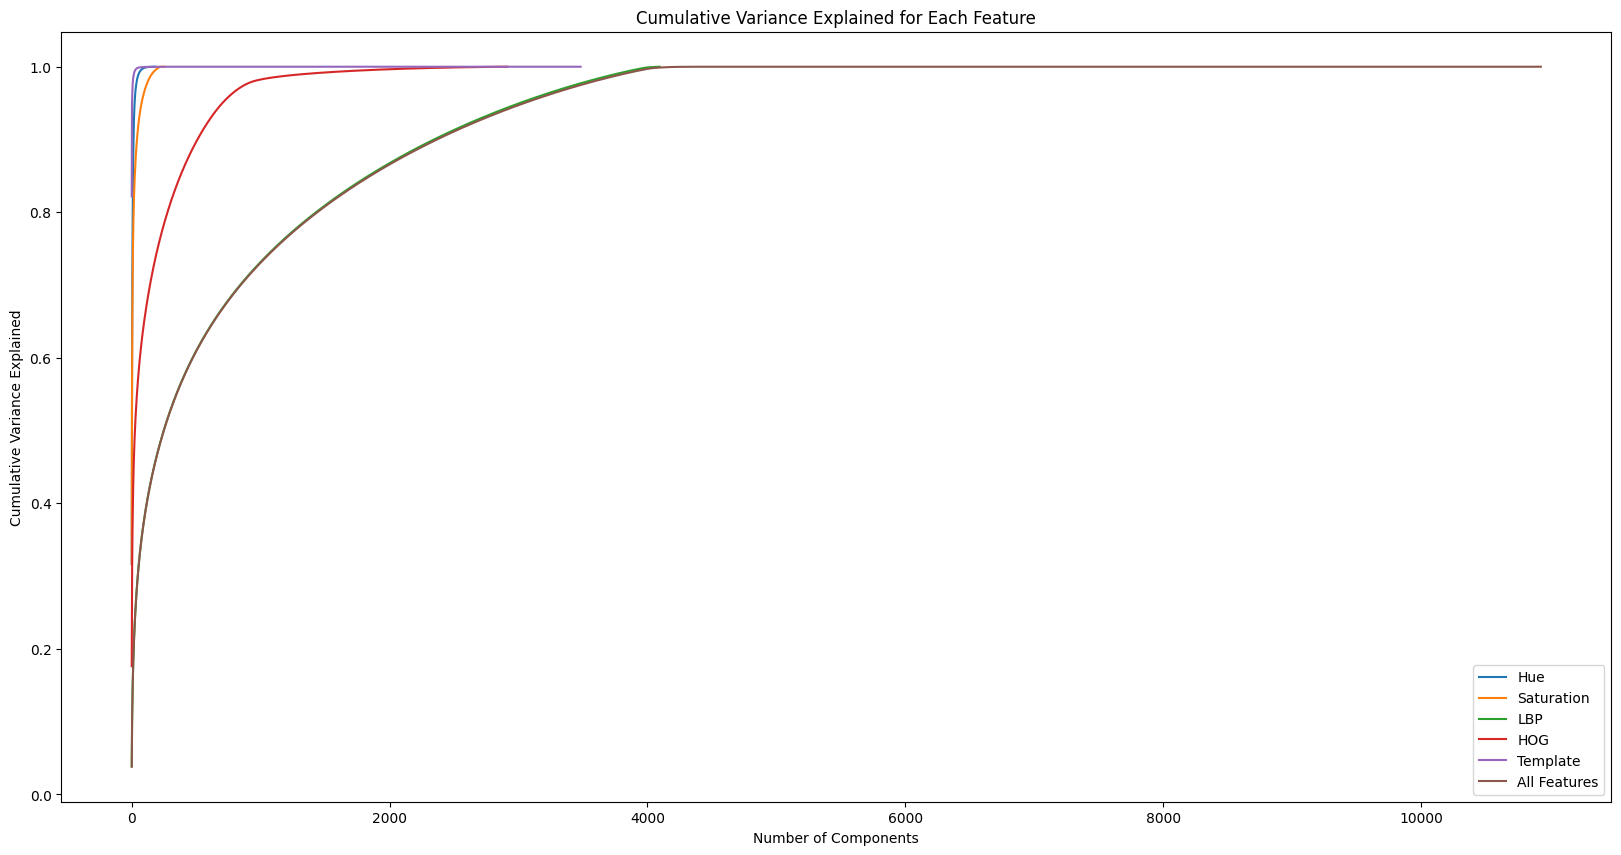

In [27]:
# plot variance explained of all features

variance_list = [
    hue_variance,
    saturation_variance,
    lbp_variance,
    hog_variance,
    template_variance,
    total_variance,
]
title = [
    "Hue",
    "Saturation",
    "LBP",
    "HOG",
    "Template",
    "All Features",
]


def plot_variance_visual(variance_list, title):
    # define figure size and subplots
    fig = plt.figure(figsize=(20, 10))
    # plot the cumulative variance explained for each feature in the same plot
    for i in range(len(variance_list)):
        plt.plot(variance_list[i][1], label=title[i])
    plt.legend()
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.title("Cumulative Variance Explained for Each Feature")
    plt.show()


# plot individual and cumulative variance explained
def plot_variance_compare(variance_vec, cust_title):
    # define figure size and subplots
    fig = plt.figure(figsize=(10, 6))
    plt.bar(
        range(0, len(variance_vec[0])),
        variance_vec[0],
        alpha=0.5,
        align="center",
        label="Individual explained variance",
    )
    plt.step(
        range(0, len(variance_vec[1])),
        variance_vec[1],
        where="mid",
        label="Cumulative explained variance",
    )
    plt.legend(loc="best")
    plt.xlabel("Number of Components")
    plt.ylabel("Variance Explained")
    plt.title(cust_title)
    plt.show()


plot_variance_visual(variance_list, title)

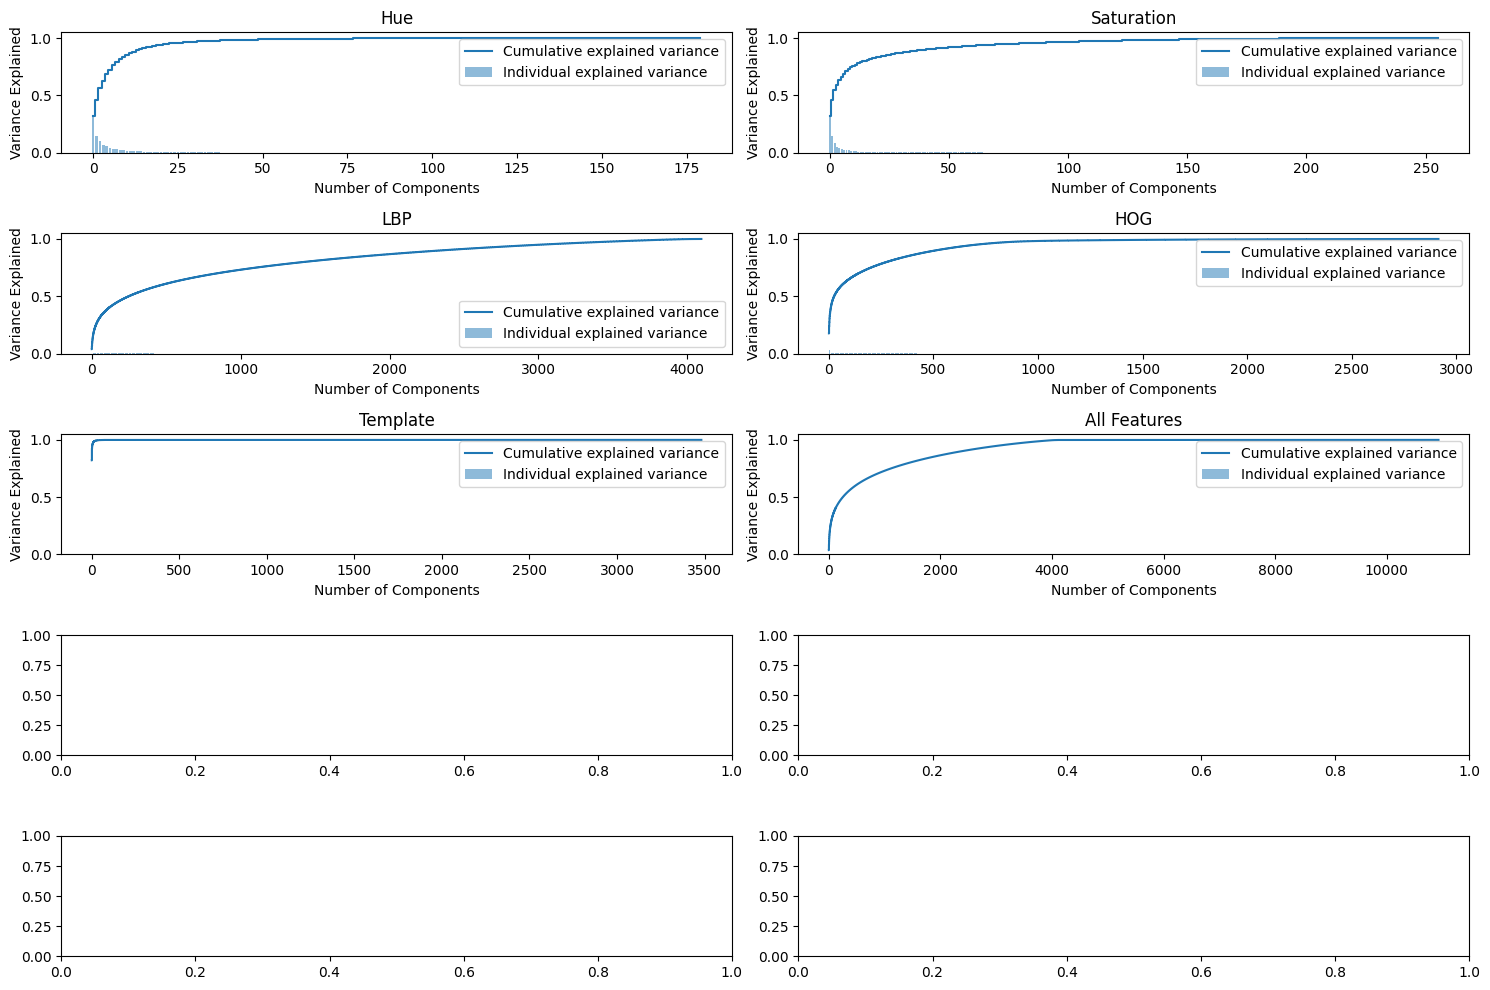

In [28]:
# create 6 subplots for each feature, 3 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
for i in range(len(variance_list)):
    axes[i // 2, i % 2].bar(
        range(0, len(variance_list[i][0])),
        variance_list[i][0],
        alpha=0.5,
        align="center",
        label="Individual explained variance",
    )
    # add step graph to plot cumulative variance explained
    axes[i // 2, i % 2].step(
        range(0, len(variance_list[i][1])),
        variance_list[i][1],
        where="mid",
        label="Cumulative explained variance",
    )
    # add legend
    axes[i // 2, i % 2].legend(loc="best")
    # add title
    axes[i // 2, i % 2].set_title(title[i])
    axes[i // 2, i % 2].set_xlabel("Number of Components")
    axes[i // 2, i % 2].set_ylabel("Variance Explained")

plt.tight_layout()
plt.show()

In [30]:
# select the top components in features_total that explain 95% of the variance
pca_total_file = Path("data/pca_total.joblib")
if not pca_total_file.exists():
    pca = PCA(n_components=0.95)
    pca.fit(features_total)
    joblib.dump(pca, pca_total_file)
else:
    pca = joblib.load(pca_total_file)
print("Number of components that explain 95% of the variance:", pca.n_components_)
features_total_pca = pca.transform(features_total)
print("Shape of features_total_pca:", features_total_pca.shape)

Number of components that explain 95% of the variance: 2510
Shape of features_total_pca: (8600, 2510)


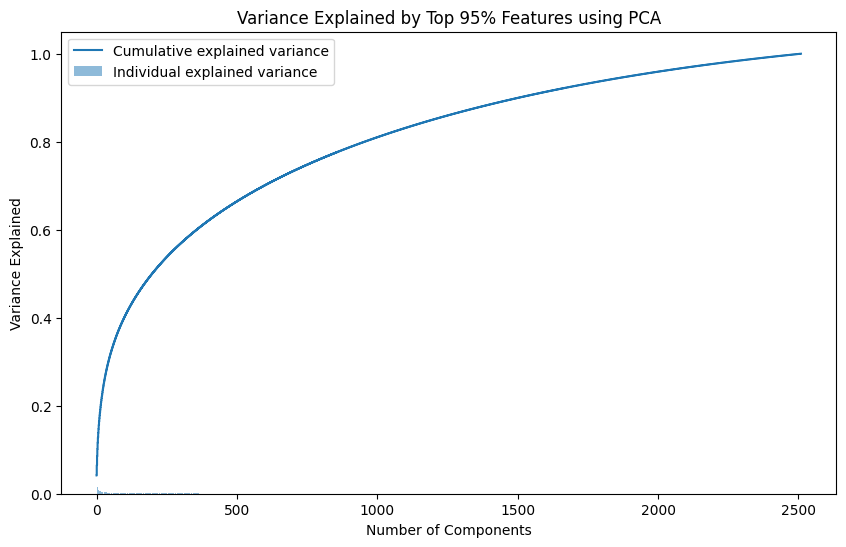

In [31]:
total_variance_pca = get_variance_explained(features_total_pca)
title_pca = "Variance Explained by Top 95% Features using PCA"
plot_variance_compare(total_variance_pca, title_pca)

#### Observation:

- In the 6 plots above, HOG and Satuation take a larger number of features to get to 80% variance explained
- Try removing HOG and Satuation feature to construct a new reduced total feature file

In [34]:
# remove HOG and Saturation features, only keep Hue, Value, and LBP
features_total_reduced = np.hstack([hue, saturation, hog, template, lbp])
features_total_reduced.shape

(8600, 10931)

In [35]:
pca_total_reduced_file = Path("data/pca_total_reduced.joblib")
if not pca_total_reduced_file.exists():
    pca = PCA()  # did not specify number of components
    pca.fit(features_total_reduced)
    joblib.dump(pca, pca_total_reduced_file)
else:
    pca = joblib.load(pca_total_reduced_file)
individual_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
individual_variance.shape

(8600,)

In [36]:
total_variance_reduced = get_variance_explained(features_total_reduced)
total_variance_reduced[0].shape

(8600,)

In [38]:
# total_variance_reduced = get_variance_explained(features_total_reduced)

# pick the top 95% variance explained
pca_total_reduced_95_file = Path("data/pca_total_reduced_95.joblib")
if not pca_total_reduced_95_file.exists():
    pca = PCA(n_components=0.95)
    pca.fit(features_total_reduced)
    joblib.dump(pca, pca_total_reduced_95_file)
else:
    pca = joblib.load(pca_total_reduced_95_file)
print("Number of components that explain 95% of the variance:", pca.n_components_)
features_total_reduced_pca = pca.transform(features_total_reduced)
print("Shape of features_total_reduced_pca:", features_total_reduced_pca.shape)

Number of components that explain 95% of the variance: 2510
Shape of features_total_reduced_pca: (8600, 2510)


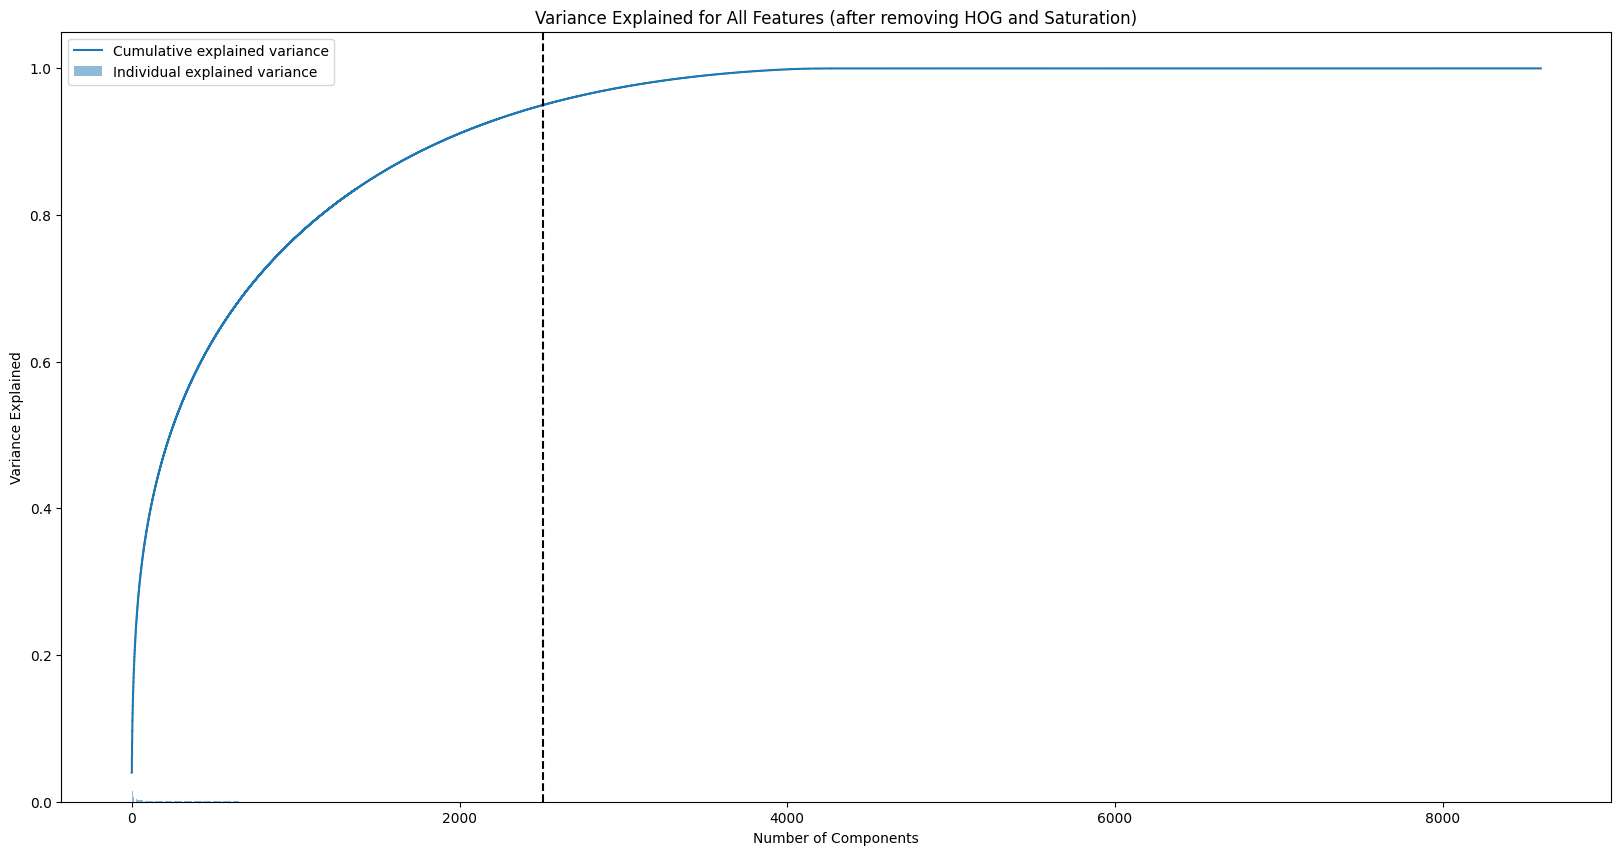

In [39]:
fig = plt.figure(figsize=(20, 10))
plt.bar(
    range(0, len(total_variance_reduced[0])),
    total_variance_reduced[0],
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(0, len(total_variance_reduced[1])),
    total_variance_reduced[1],
    where="mid",
    label="Cumulative explained variance",
)
plt.legend(loc="best")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.title("Variance Explained for All Features (after removing HOG and Saturation)")
# add vertical line to show the number of components that explain 95% of the variance
plt.axvline(x=features_total_reduced_pca.shape[1], color="k", linestyle="--")

plt.show()

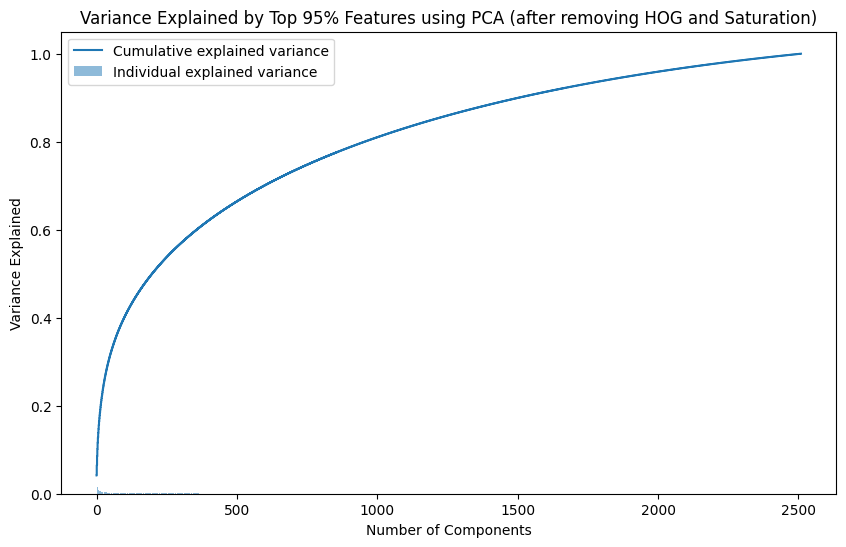

In [40]:
total_variance_reduced_pca = get_variance_explained(features_total_reduced_pca)
title_reduced_pca = "Variance Explained by Top 95% Features using PCA (after removing HOG and Saturation)"
plot_variance_compare(total_variance_reduced_pca, title_reduced_pca)

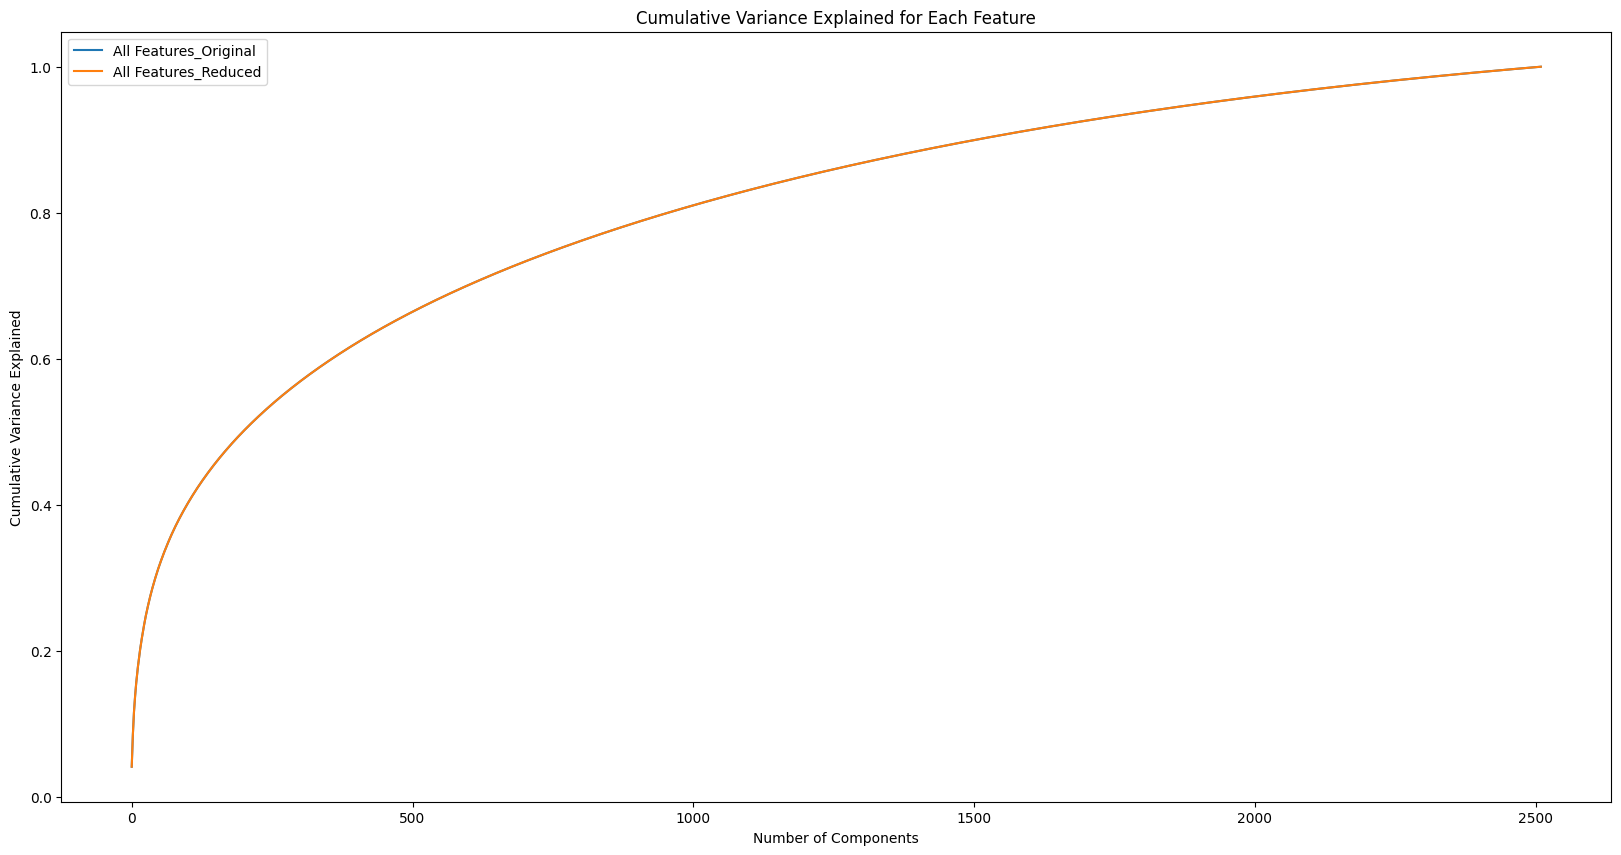

In [41]:
# after reducing the top 95% features, compare the variance explained for all features and reduced features

variance_list_2 = [total_variance_pca, total_variance_reduced_pca]
title_2 = ["All Features_Original", "All Features_Reduced"]

# def plot_variance_visual (variance_list, title):
#     # define figure size and subplots
#     fig = plt.figure(figsize=(20, 10))
#     # plot the cumulative variance explained for each feature in the same plot
#     for i in range(len(variance_list)):
#         plt.plot(variance_list[i][1], label=title[i])
#     plt.legend()
#     plt.xlabel("Number of Components")
#     plt.ylabel("Cumulative Variance Explained")
#     plt.title("Cumulative Variance Explained for Each Feature")
#     plt.show()

plot_variance_visual(variance_list_2, title_2)

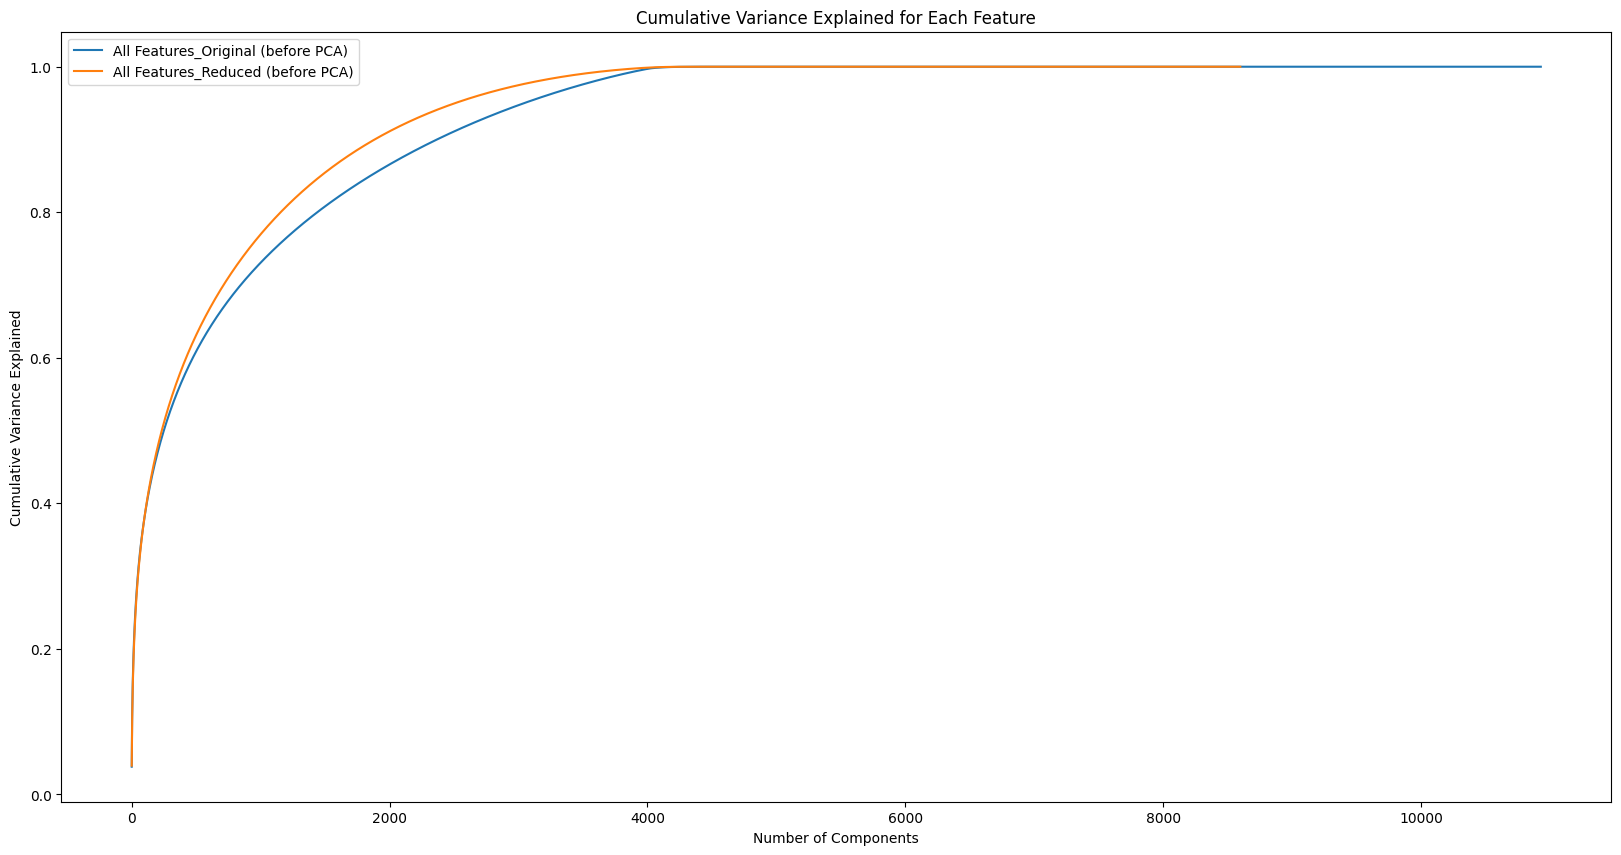

In [42]:
# BEFORE reducing the top 95% features, compare the variance explained for all features and reduced features

variance_list_before = [total_variance, total_variance_reduced]
title_before = [
    "All Features_Original (before PCA)",
    "All Features_Reduced (before PCA)",
]

plot_variance_visual(variance_list_before, title_before)

### T-distributed Stochastic Neighbor Embedding (t-SNE) Visualization

In [43]:
tsne = TSNE(
    n_components=2, random_state=42, verbose=1
)  # remove verbose=1 if you do not want to see the progress bar

In [45]:
# apply TSNE to individual and combined features
tsne_results_file = Path("data/tsne_results.joblib")
if not tsne_results_file.exists():
    hue_tsne = tsne.fit_transform(hue)
    saturation_tsne = tsne.fit_transform(saturation)
    lbp_tsne = tsne.fit_transform(lbp)
    hog_tsne = tsne.fit_transform(hog)
    template_tsne = tsne.fit_transform(template)
    total_reduced_tsne = tsne.fit_transform(features_total_reduced)
    total_reduced_pca_tsne = tsne.fit_transform(features_total_reduced_pca)
    joblib.dump(
        {
            "hue_tsne": hue_tsne,
            "sat_tsne": saturation_tsne,
            "lbp_tsne": lbp_tsne,
            "hog_tsne": hog_tsne,
            "tem_tsne": template_tsne,
            "tot_reduced_tsne": total_reduced_tsne,
            "tot_reduced_pca_tsne": total_reduced_pca_tsne,
        },
        tsne_results_file,
    )
else:
    loaded_tsne = joblib.load(tsne_results_file)
    hue_tsne = loaded_tsne["hue_tsne"]
    saturation_tsne = loaded_tsne["sat_tsne"]
    lbp_tsne = loaded_tsne["lbp_tsne"]
    hog_tsne = loaded_tsne["hog_tsne"]
    template_tsne = loaded_tsne["tem_tsne"]
    total_reduced_tsne = loaded_tsne["tot_reduced_tsne"]
    total_reduced_pca_tsne = loaded_tsne["tot_reduced_pca_tsne"]

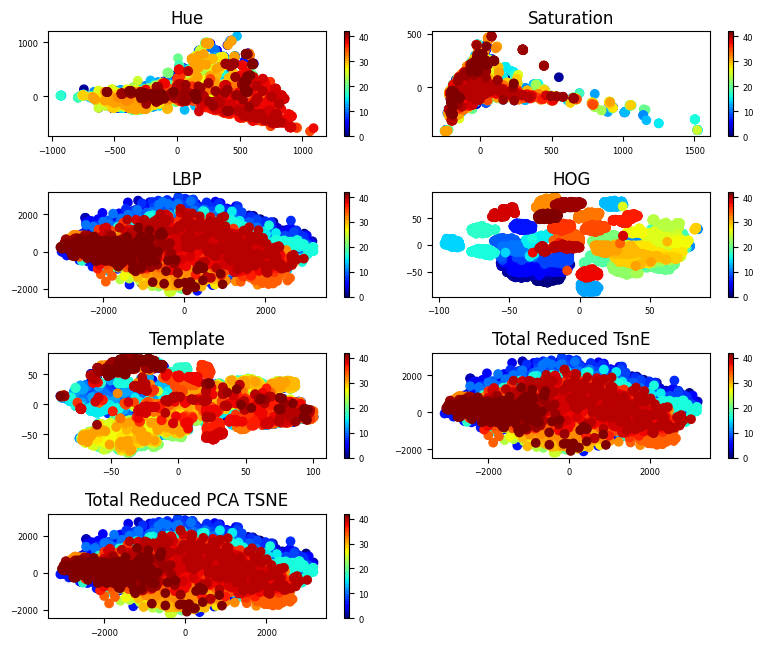

In [46]:
# features_list = [hue_tsne, saturation_tsne, value_tsne, lbp_tsne, hog_tsne, total_tsne, total_reduced_tsne, total_reduced_pca_tsne]
# title_list = ["Hue", "Saturation", "Value", "LBP", "HOG", "All Features", "Reduced Features", "Reduced Features (after PCA)"]

features_list = [
    hue_tsne,
    saturation_tsne,
    lbp_tsne,
    hog_tsne,
    template_tsne,
    total_reduced_tsne,
    total_reduced_pca_tsne,
]
title_list = [
    "Hue",
    "Saturation",
    "LBP",
    "HOG",
    "Template",
    "Total Reduced TsnE",
    "Total Reduced PCA TSNE",
]


# define a function to plot TSNE results for 6 features, 2 rows and 4 columns
def plot_tsne(features_list, title_list):
    fig = plt.figure(figsize=(8, 8))
    for i in range(len(features_list)):
        plt.subplot(5, 2, i + 1)
        plt.scatter(
            features_list[i][:, 0],
            features_list[i][:, 1],
            c=dft["ClassId"],
            cmap=plt.cm.get_cmap("jet", 43),
        )
        # plt.colorbar(ticks=range(43))
        # plt.clim(-0.5, 42.5)
        # change the colorbar label font size
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=6)
        # change font size for x and y ticks
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.title(title_list[i])
    plt.tight_layout()
    plt.show()


plot_tsne(features_list, title_list)

In [48]:
def plot_sns_tsne(features_list, title_list):
    for i in range(len(features_list)):
        # create a dataframe to store the TSNE results
        df_tsne = pl.DataFrame()
        # add ClassId column to the dataframe
        df_tsne["ClassId"] = dft["ClassId"]
        # add the TSNE results to the dataframe
        df_tsne["comp-1"] = features_list[i][:, 0]
        df_tsne["comp-2"] = features_list[i][:, 1]
        # create a figure
        sns.scatterplot(
            x="comp-1",
            y="comp-2",
            hue=df_tsne["ClassId"].tolist(),
            palette=sns.color_palette("hls", 3),
            data=df_tsne,
        ).set(title=title_list[i])
        # put hue legend to the bottom outside of the plot
        # plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
        # wrap the legend if the legend is too long
        plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, loc="upper left", ncol=2)
        # change the font size for hue legend
        plt.setp(plt.gca().get_legend().get_texts(), fontsize="6")
        # change font size for x and y ticks
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        # plt.tight_layout()
        plt.show()


plot_sns_tsne(features_list, title_list)

TypeError: DataFrame object does not support `Series` assignment by index

Use `DataFrame.with_columns`.

### Check Features images   [from Ed's Check Features.ipynb]

In [ ]:
h_ymin = 0
h_ymax = (
    0.15  # This will clip some high values but provide better overall visualization
)
random_seed = 42
num_samples_per_class = 1
for i in range(43):
    class_members = dft.filter(pl.col("ClassId") == i)
    samples = class_members.sample(
        num_samples_per_class, with_replacement=False, seed=random_seed
    )

    print(132 * "=")
    print(f"Class: {i} Description: {samples['Description'][0]}")

    for j, sample in enumerate(samples.iter_rows(named=True)):
        fig = plt.figure(figsize=(24, 4))
        nrows = 1
        ncols = 8

        ########################################################################
        # Plot original image
        original_image = np.load(BytesIO(sample["Meta_Image"]))
        original_image = (original_image * 255).astype(np.uint8)
        ax = fig.add_subplot(nrows, ncols, 1)
        ax.imshow(original_image)
        ax.set_title("Meta image")

        ########################################################################
        # Plot original image
        original_image = np.load(BytesIO(sample["Image"]))
        original_image = (original_image * 255).astype(np.uint8)
        ax = fig.add_subplot(nrows, ncols, 2)
        ax.imshow(original_image)
        ax.set_title("Original image")

        ########################################################################
        # Plot Hog Image
        hog_image = np.load(BytesIO(sample["HOG_Image"]))
        ax = fig.add_subplot(nrows, ncols, 3)
        ax.imshow(hog_image)
        ax.set_title("HOG Image")

        ########################################################################
        # Plot Hue Histogram
        hue_hist = np.asarray(sample["Hue_Hist"])
        hue_edges = np.histogram_bin_edges(hue_hist, bins=180, range=(0, 180))
        hue_centers = 0.5 * (hue_edges[1:] + hue_edges[:-1])
        hue_normalized = normalize_histogram(hue_hist)
        ax = fig.add_subplot(nrows, ncols, 4)
        plt.bar(
            hue_centers,
            hue_normalized,
            width=(hue_edges[1] - hue_edges[0]),
            color="red",
            label="Hue",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Hue Histogram")

        ########################################################################
        # Plot Saturation Histogram
        sat_hist = np.asarray(sample["Saturation_Hist"])
        sat_edges = np.histogram_bin_edges(sat_hist, bins=256, range=(0, 256))
        sat_centers = 0.5 * (sat_edges[1:] + sat_edges[:-1])
        sat_normalized = normalize_histogram(sat_hist)
        ax = fig.add_subplot(nrows, ncols, 5)
        plt.bar(
            sat_centers,
            sat_normalized,
            width=(sat_edges[1] - sat_edges[0]),
            color="green",
            label="Saturation",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Saturation Histogram")

        ########################################################################
        # Plot Value Histogram
        val_hist = np.asarray(sample["Value_Hist"])
        val_edges = np.histogram_bin_edges(val_hist, bins=256, range=(0, 256))
        val_centers = 0.5 * (val_edges[1:] + val_edges[:-1])
        val_normalized = normalize_histogram(val_hist)
        ax = fig.add_subplot(nrows, ncols, 6)
        plt.bar(
            val_centers,
            val_normalized,
            width=(val_edges[1] - val_edges[0]),
            color="blue",
            label="Value",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Value Histogram")

        ########################################################################
        # Plot LBP Image
        lbp_image = np.load(BytesIO(sample["LBP_Image"]))
        ax = fig.add_subplot(nrows, ncols, 7)
        ax.imshow(lbp_image)
        ax.set_title("LBP Image")

        ########################################################################
        # Plot LBP Histogram
        lbp_hist = np.array(sample["LBP_Hist"])
        lbp_edges = np.histogram_bin_edges(lbp_hist, bins=18, range=(0, 18))
        lbp_normalized_hist = normalize_histogram(lbp_hist)
        lbp_centers = 0.5 * (lbp_edges[1:] + lbp_edges[:-1])
        ax = fig.add_subplot(nrows, ncols, 8)
        plt.bar(
            lbp_centers,
            lbp_normalized_hist,
            width=(lbp_edges[1] - lbp_edges[0]),
            color="blue",
            edgecolor="black",
            label="LBP",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Local Binary Pattern Histogram")

        plt.tight_layout()
        plt.show()